In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stations = pd.read_csv("C:\\Users\\User\\Documents\\4. Fourth Year\\Project\\Railway-Fares\\Data\\Cleansed Data\\station.csv")

In [3]:
crs_scope = list(stations["CRS"])

In [4]:
with open(r"C:\Users\User\Documents\4. Fourth Year\Project\Railway-Fares\Data\Timetable Data\ttisf194.mca", 'r') as f:
    records = f.read().split('\n')

In [5]:
tiploc = list(filter(lambda x: x[:2] == 'TI', records))

In [6]:
tiploc_scope  = list(filter(lambda x: x[53:56] in crs_scope, tiploc))
tiploc_to_crs = {x[2:9]: x[53:56] for x in tiploc_scope}
crs_to_tiploc = {x[53:56]: x[2:9] for x in tiploc_scope}

In [7]:
tiploc_scope = list(map(lambda x: x[2:9], tiploc_scope))

In [8]:
routes = []
currently_reading = False
for record in records:
    if currently_reading:
        if record[:2] == "LT" and record[2: 9] in tiploc_scope:
            current_route.append(record)
            routes.append(current_route)
            currently_reading = False
            
        elif record[:2] == "LI":
            current_route.append(record)
        
        else:
            continue
            
    
    else:
        if record[:2] == "LO" and record[2: 9] in tiploc_scope:
            current_route = [record,]
            currently_reading = True
        else:
            continue

In [9]:
len(routes)

15844

In [10]:
len(tiploc_scope)

360

In [11]:
routes_cleansed = []
for route in routes:
    route_cleansed = []
    for stop in route:
        if stop[2:9] in tiploc_scope:
            if stop[:2] == "LO":
                route_cleansed.append([stop[2:9], stop[10:14]])
            elif stop[:2] == "LI" and stop[10:14] != "    ":
                route_cleansed.append([stop[2:9], stop[10:14], stop[15:19]])
            elif stop[:2] == "LT":
                route_cleansed.append([stop[2:9], stop[10:14]])
    routes_cleansed.append(route_cleansed)

In [12]:
routes_cleansed[1]

[['EDINBUR', '0908'],
 ['HAYMRKT', '0911', '0913'],
 ['IVRKTHG', '0931', '0933'],
 ['KCLD   ', '0948', '0950'],
 ['LEUCHRS', '1013', '1015'],
 ['DUNDETB', '1028', '1030'],
 ['ARBROTH', '1045', '1047'],
 ['MONTRSE', '1101', '1103'],
 ['SHVN   ', '1125', '1127'],
 ['ABRDEEN', '1145']]

In [13]:
def get_travel_time(stop1, stop2):
    if  stop1[0] != stop2[0]:
        if len(stop1) == 2:
            t1 = int(stop1[1][:2]) * 60 + int(stop1[1][2:4])
        elif len(stop1) == 3:
            t1 = int(stop1[2][:2]) * 60 + int(stop1[2][2:4])

        t2 = int(stop2[1][:2]) * 60 + int(stop2[1][2:4])

        travel_time = t2 - t1

        if not (travel_time < 0 or travel_time > 3*60):
            return tiploc_to_crs[stop1[0]], tiploc_to_crs[stop2[0]], travel_time
    

tiploc_enum = zip(tiploc_scope, range(len(tiploc_scope)))
tiploc_to_node = {x[0]: x[1] for x in tiploc_enum}
node_to_tiploc = {x[1]: x[0] for x in tiploc_enum}

In [14]:
get_travel_time(routes_cleansed[1][1], routes_cleansed[1][2])

('HYM', 'INK', 18)

In [15]:
import networkx as nx

In [16]:
dg = nx.DiGraph()

for route in routes_cleansed:
    edges = filter(lambda x: x is not None, [get_travel_time(pair[0], pair[1]) for pair in zip(route, route[1:])])
    dg.add_weighted_edges_from(edges)

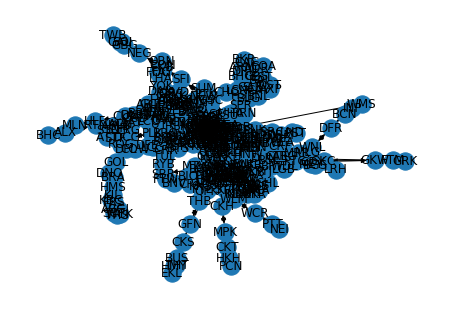

In [17]:
nx.draw(dg, with_labels = True)
plt.show()

In [18]:
from networkx.algorithms.shortest_paths.generic import shortest_path
from networkx.classes.function import path_weight
from itertools import product

def get_route_info(origin, dest):
    path = shortest_path(dg, origin, dest, weight = "weight")
    time = path_weight(dg, path, weight = "weight")
    
    return time, len(path)

In [19]:
crs_all_routes = list(filter(lambda x: x[0] != x[1], product(crs_scope, crs_scope)))

In [20]:
routes_info = []
failures = []
for crs_route in crs_all_routes:
    try:
        routes_info.append([*crs_route, *get_route_info(*crs_route)])
    except Exception:
        failures.append(crs_route)

In [21]:
len(routes_info), len(failures)

(130676, 724)

In [30]:
route_lengths = pd.DataFrame(routes_info, columns = ["CRS.origin", "CRS.dest", "Time/min", "Stops"])

In [31]:
route_lengths = route_lengths.merge(stations[["CRS", "NLC"]], left_on = "CRS.origin", right_on = "CRS")
route_lengths = route_lengths.merge(stations[["CRS", "NLC"]], left_on = "CRS.dest", right_on = "CRS", suffixes = (".origin", ".dest"))

C:\Users\User\anaconda3\envs\py3iaml\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'CRS.origin'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


In [32]:
route_lengths = route_lengths[["NLC.origin", "NLC.dest", "Time/min", "Stops"]]


In [33]:
route_lengths["Stops"] = route_lengths["Stops"] - 2

In [34]:
route_lengths.to_csv("C:\\Users\\User\\Documents\\4. Fourth Year\\Project\\Railway-Fares\\Data\\Cleansed Data\\route_lengths.csv", index = False)